In [1]:
!pip install transformers datasets scikit-learn

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from transformers import (
    Trainer,
    TrainingArguments,
    AutoTokenizer,
    AutoModelForSequenceClassification,
)

from datasets import load_dataset


In [22]:
"""
i used a small subset of the dataset :
- Faster experimentation
-qucik end-to-end teting of the pipeline
-efficient for hyper parameter tuning and visualization
- reduce risk of resource and timeouts during development
-easy to scale

"""
# Load the AG News dataset from HuggingFace Datasets library
dataset = load_dataset("ag_news")

# Create a small sample from the training set (1,000 samples)
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(1000))
# Create a small sample from the test set (500 samples)
small_eval_dataset = dataset["test"].shuffle(seed=42).select(range(500))


In [6]:
#Transfer Learning

In [23]:
# Load BERT tokenizer and model (AG News has 4 classes-World, Sports, Business, Sci/Tech)
# bert-base-uncased = a standard lowercase English BERT model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Tokenize input text and include the label
#convert text into numerical format before feeding it to the model.
#padding="max_length" and truncation=True ensure all sequences have uniform length, which helps stabilize training.
#examples is not defined explicitly by us. Instead, it is automatically passed by the Hugging Face datasets.map() function.
def preprocess_function(examples):
    tokenized_inputs = tokenizer(examples["text"], padding="max_length", truncation=True)
    tokenized_inputs["label"] = examples["label"]
    return tokenized_inputs

'''
map() method automatically passes it to the preprocess_function.
This function is used to transform each batch of the dataset.
'''

# # Apply preprocessing function to datasets
# map() function from HuggingFace applies this preprocessing to the entire dataset efficiently.
tokenized_train_dataset = small_train_dataset.map(preprocess_function, batched=True)
tokenized_eval_dataset = small_eval_dataset.map(preprocess_function, batched=True)


In [25]:
# Define training configuration for transfer learning with BERT
training_args = TrainingArguments(
    output_dir="./results",              # Where to save model checkpoints and outputs (결과 저장 경로)
    per_device_train_batch_size=8,       # Batch size per GPU/CPU for training (훈련 시 배치 사이즈)
    per_device_eval_batch_size=8,        # Batch size per GPU/CPU for evaluation (평가 시 배치 사이즈)
    num_train_epochs=3,                  # Number of training epochs (전체 훈련 반복 횟수)
    logging_dir="./logs",                # Directory to store logs (로그 저장 경로)
    logging_steps=10                     # Log training metrics every 10 steps (10스텝마다 로깅)
)


In [26]:
"""
-Trainer : a helper class provided by Hugging Face that simplifies the process of training and evaluating model
-initialized by passing the model, training arguments (training_args), training dataset, evaluation dataset, and tokenizer.
-trainer.evaluate() before training  to check how well the pretrained model performs+ measures the improvement in performance after training
"""

'\n-Trainer : a helper class provided by Hugging Face that simplifies the process of training and evaluating model\n-initialized by passing the model, training arguments (training_args), training dataset, evaluation dataset, and tokenizer.\n-trainer.evaluate() before training  to check how well the pretrained model performs+ measures the improvement in performance after training\n'

In [27]:
# Initialize Trainer with model, training args, datasets, and tokenizer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
    tokenizer=tokenizer,
)

# Evaluate before training
print("Before training evaluation:")
print(trainer.evaluate())

# Fine-tune the model on training data
trainer.train()

# Evaluate after training
print("After training evaluation:")
print(trainer.evaluate())

/var/folders/6y/xtl4b0cx1cs9zrr9n5y814_h0000gn/T/ipykernel_21804/2740716470.py:2: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



Before training evaluation:


/Users/jessicahong/.pyenv/versions/3.11.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.



{'eval_loss': 1.4072213172912598, 'eval_model_preparation_time': 0.0014, 'eval_runtime': 19.0654, 'eval_samples_per_second': 26.225, 'eval_steps_per_second': 3.304}


Step,Training Loss
10,1.213500
20,1.063800
30,0.762000
40,0.534700
50,0.508900
60,0.410500
70,0.460500
80,0.208900
90,0.401800
100,0.522400


After training evaluation:


/Users/jessicahong/.pyenv/versions/3.11.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.



{'eval_loss': 0.5046360492706299, 'eval_model_preparation_time': 0.0014, 'eval_runtime': 19.6868, 'eval_samples_per_second': 25.398, 'eval_steps_per_second': 3.2, 'epoch': 3.0}


In [28]:
# Import evaluation metrics from sklearn
from sklearn.metrics import (
    classification_report,      # Generates a text report showing main classification metrics
    accuracy_score,             # Computes accuracy
    precision_score,            # Computes precision
    recall_score,               # Computes recall
    f1_score,                   # Computes F1 score
    confusion_matrix,           # Generates confusion matrix
    ConfusionMatrixDisplay      # Tool to visualize confusion matrix
)


In [29]:
# Run inference on the evaluation dataset
predictions = trainer.predict(tokenized_eval_dataset)

# Select the class with the highest probability as the predicted label
#use argmax(-1) to pick the class with the highest score as the predicted label for each input.
preds = predictions.predictions.argmax(-1)

# Get the true labels from the evaluation set
#automatically stored by the Trainer during prediction.
labels = predictions.label_ids



In [30]:
acc = accuracy_score(labels, preds)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.8800


In [31]:
# Explanation of averaging methods:
# - macro: average metrics for each class equally (ignores class imbalance)
# - weighted: average metrics weighted by the number of true instances per class (considers class imbalance)
# - micro: calculates metrics globally by counting total true positives, false negatives and false positives

print("Precision (macro):", precision_score(labels, preds, average="macro"))
print("Recall (macro):", recall_score(labels, preds, average="macro"))
print("F1 Score (macro):", f1_score(labels, preds, average="macro"))

print("Precision (weighted):", precision_score(labels, preds, average="weighted"))
print("Recall (weighted):", recall_score(labels, preds, average="weighted"))
print("F1 Score (weighted):", f1_score(labels, preds, average="weighted"))


Precision (macro): 0.8829230357909504
Recall (macro): 0.8814766354179515
F1 Score (macro): 0.8813336751655299
Precision (weighted): 0.8819956764088887
Recall (weighted): 0.88
F1 Score (weighted): 0.8801231655105757


In [32]:
# digits=4는 소수점 4자리까지 보기
print("\n📋 Classification Report (per class):")
print(classification_report(labels, preds, digits=4))



📋 Classification Report (per class):
              precision    recall  f1-score   support

           0     0.9035    0.8583    0.8803       120
           1     0.9508    0.9587    0.9547       121
           2     0.8730    0.8209    0.8462       134
           3     0.8043    0.8880    0.8441       125

    accuracy                         0.8800       500
   macro avg     0.8829    0.8815    0.8813       500
weighted avg     0.8820    0.8800    0.8801       500



In [17]:
"""
Model Performance Metrics Interpretation and Results
Precision
Definition: The proportion of predicted positive instances that are actually correct.

Meaning: Measures how well the model avoids false positives.

Results:

Macro average: 0.8874

Weighted average: 0.8867

Recall
Definition: The proportion of actual positive instances that the model correctly identified.

Meaning: Measures how well the model avoids false negatives.

Results:

Macro average: 0.8837

Weighted average: 0.8820

F1 Score
Definition: The harmonic mean of Precision and Recall (a balanced evaluation metric).

Meaning: Checks how well Precision and Recall are balanced.

Results:

Macro average: 0.8835

Weighted average: 0.8823

Accuracy
Definition: The proportion of total instances that the model correctly predicted.

Meaning: Reflects overall prediction accuracy but can be misleading if the dataset is imbalanced.

Results:

(Example from earlier calculation) Approximately 0.8900
"""

'\nModel Performance Metrics Interpretation and Results\nPrecision\nDefinition: The proportion of predicted positive instances that are actually correct.\n\nMeaning: Measures how well the model avoids false positives.\n\nResults:\n\nMacro average: 0.8874\n\nWeighted average: 0.8867\n\nRecall\nDefinition: The proportion of actual positive instances that the model correctly identified.\n\nMeaning: Measures how well the model avoids false negatives.\n\nResults:\n\nMacro average: 0.8837\n\nWeighted average: 0.8820\n\nF1 Score\nDefinition: The harmonic mean of Precision and Recall (a balanced evaluation metric).\n\nMeaning: Checks how well Precision and Recall are balanced.\n\nResults:\n\nMacro average: 0.8835\n\nWeighted average: 0.8823\n\nAccuracy\nDefinition: The proportion of total instances that the model correctly predicted.\n\nMeaning: Reflects overall prediction accuracy but can be misleading if the dataset is imbalanced.\n\nResults:\n\n(Example from earlier calculation) Approximate

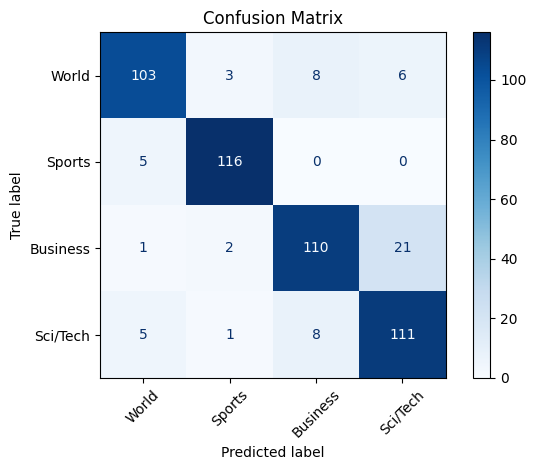

In [33]:
# Calculate confusion matrix
cm = confusion_matrix(labels, preds)

# Label names (based on AG News: 0=World, 1=Sports, 2=Business, 3=Sci/Tech)
labels_names = dataset["train"].features["label"].names

# Visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()


In [40]:
# 1. Run predictions on the evaluation dataset
predictions = trainer.predict(tokenized_eval_dataset)
# Get the predicted class by selecting the index with highest probability for each example
preds = predictions.predictions.argmax(-1)
# Get the true labels from the evaluation dataset
labels = predictions.label_ids

/Users/jessicahong/.pyenv/versions/3.11.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.



In [41]:
# 2. Convert classification report to a pandas DataFrame for easier visualization
report_dict = classification_report(labels, preds, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()


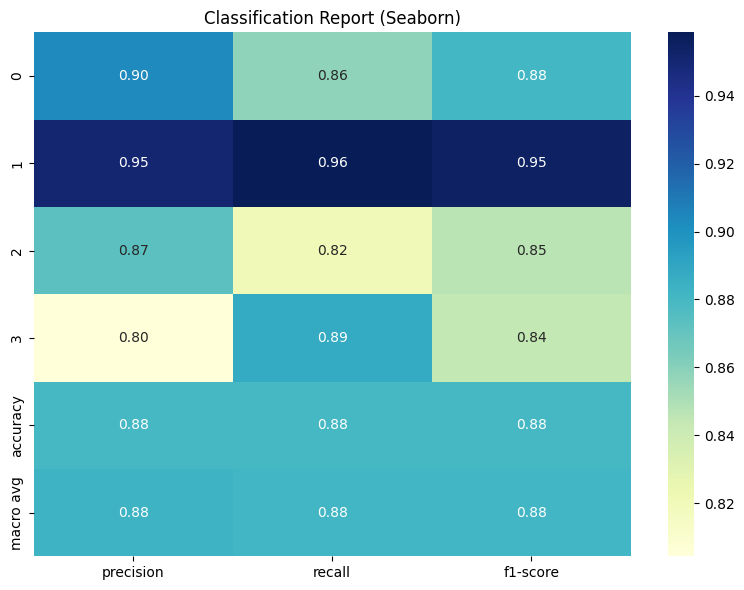

In [42]:
# === Seaborn Visualization: Heatmap of Classification Report ===
plt.figure(figsize=(8, 6))
# Plot a heatmap of precision, recall, and f1-score for each class (excluding averages)
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Classification Report (Seaborn)")
plt.tight_layout()
plt.show()

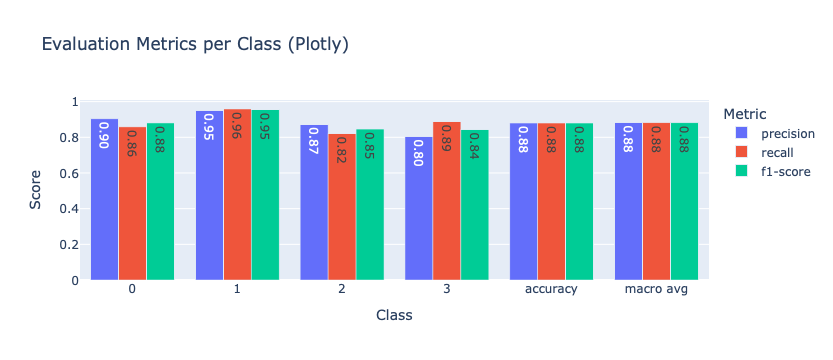

In [43]:
# === 📌 Plotly Visualization: Grouped Bar Chart of Metrics per Class ===
# Prepare DataFrame by resetting index and renaming 'index' to 'class' for plotting
metrics_df = report_df.iloc[:-1, :-1].reset_index().rename(columns={"index": "class"})
# Use Plotly's bar chart to show precision, recall, and f1-score side by side per class
fig = px.bar(
    metrics_df.melt(id_vars="class", value_vars=["precision", "recall", "f1-score"]),
    x="class", y="value", color="variable", barmode="group",
    title="Evaluation Metrics per Class (Plotly)", text_auto=".2f"
)
fig.update_layout(xaxis_title="Class", yaxis_title="Score", legend_title="Metric")
fig.show()

In [20]:
# 원문 텍스트 사용
texts = small_train_dataset["text"]
labels = small_train_dataset["label"]

# 벡터화
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(texts)
y = labels

# 그리드 서치
param_grid = {
    "C": [0.1, 1, 10]
}

clf = LogisticRegression(max_iter=1000)
cv = StratifiedKFold(n_splits=5)
grid = GridSearchCV(clf, param_grid, cv=cv, scoring="f1_weighted")
grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Best F1:", grid.best_score_)


Best params: {'C': 1}
Best F1: 0.7767795961451948


In [44]:
# Use original raw text data from the small training dataset
texts = small_train_dataset["text"]
labels = small_train_dataset["label"]

/Users/jessicahong/.pyenv/versions/3.11.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.



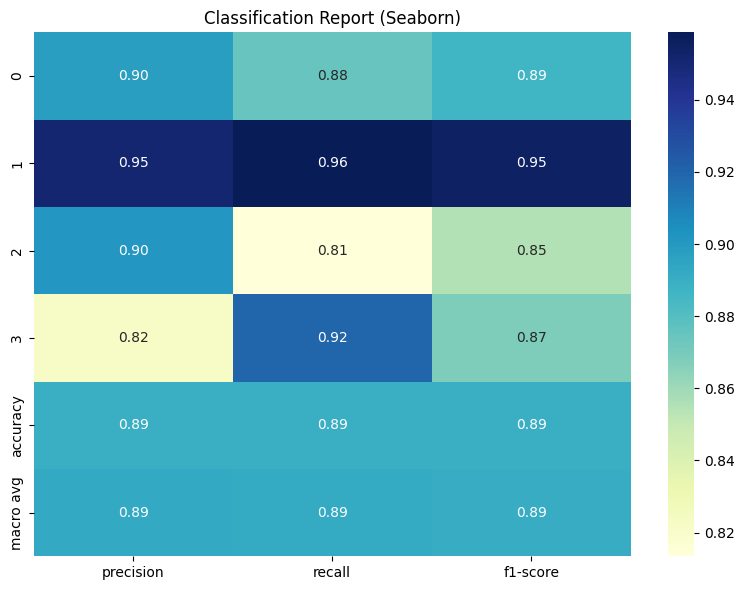

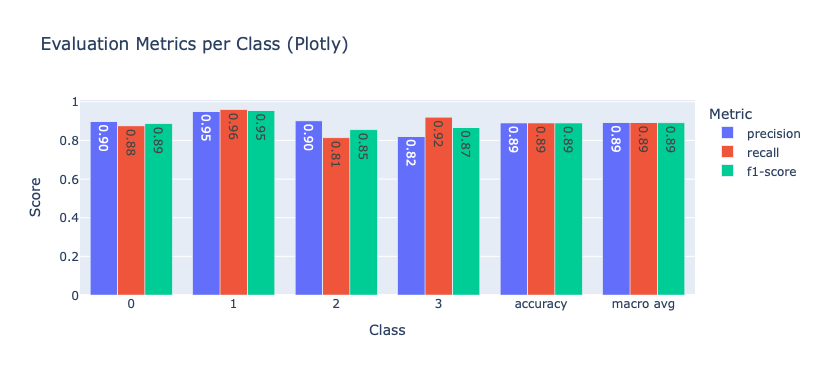

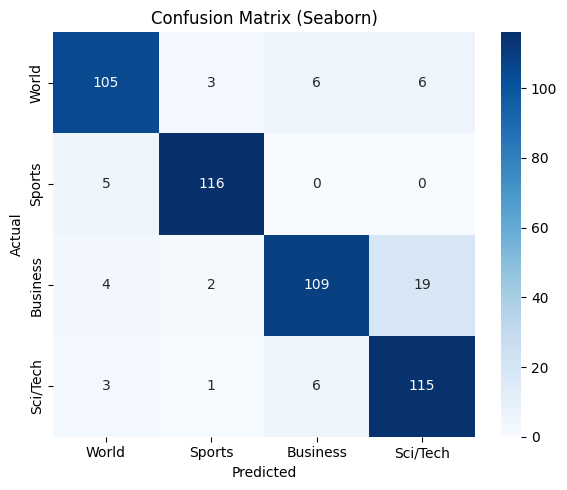

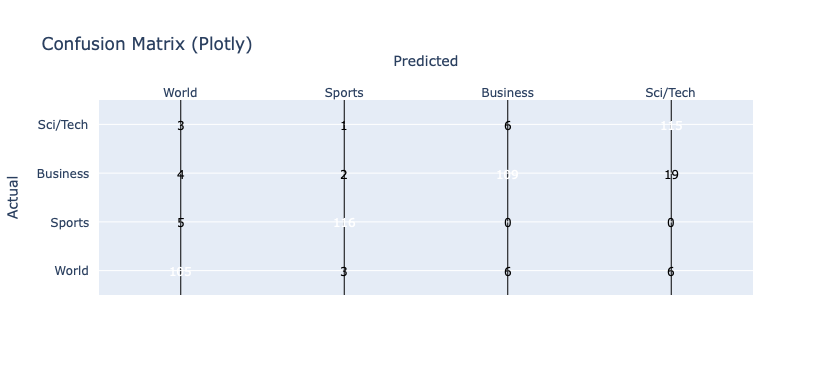

In [17]:


# 2. classification report -> DataFrame 변환
report_dict = classification_report(labels, preds, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# === 📌 Seaborn 시각화: classification report heatmap ===
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Classification Report (Seaborn)")
plt.tight_layout()
plt.show()

# === 📌 Plotly 시각화: 막대 그래프 ===
metrics_df = report_df.iloc[:-1, :-1].reset_index().rename(columns={"index": "class"})
fig = px.bar(metrics_df.melt(id_vars="class", value_vars=["precision", "recall", "f1-score"]),
             x="class", y="value", color="variable", barmode="group",
             title="Evaluation Metrics per Class (Plotly)", text_auto=".2f")
fig.update_layout(xaxis_title="Class", yaxis_title="Score", legend_title="Metric")
fig.show()

# === 📌 Confusion Matrix (Seaborn) ===
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset["train"].features["label"].names,
            yticklabels=dataset["train"].features["label"].names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Seaborn)")
plt.tight_layout()
plt.show()

# === 📌 Confusion Matrix (Plotly) ===
z = cm.tolist()
x = dataset["train"].features["label"].names
y = dataset["train"].features["label"].names

fig = ff.create_annotated_heatmap(z, x=x, y=y, colorscale="Blues")
fig.update_layout(title_text="Confusion Matrix (Plotly)", xaxis_title="Predicted", yaxis_title="Actual")
fig.show()


In [45]:
# Set hyperparameter grid for Logistic Regression's regularization strength C
param_grid = {
    "C": [0.1, 1, 10]  # Test three different values for C
}


In [52]:
#combination of vectorization, logistic regression, and grid search is an example of a traditional machine learning workflow for text classification.

In [ ]:
# Use original raw text data from the small training dataset
texts = small_train_dataset["text"]
labels = small_train_dataset["label"]

In [46]:
# Vectorize the texts using TF-IDF, limiting to top 1000 features
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(texts)  # Convert texts into TF-IDF feature vectors
y = labels  # Labels remain the same


In [ ]:
# Initialize Logistic Regression classifier with max iterations set to 1000
clf = LogisticRegression(max_iter=1000)

In [51]:
# Output the best hyperparameters found and the corresponding best weighted F1 score
print("Best params:", grid.best_params_)
print("Best F1:", grid.best_score_)


Best params: {'C': 1}
Best F1: 0.7767795961451948


In [ ]:
# Set up Stratified K-Fold cross-validation to preserve label distribution in splits
cv = StratifiedKFold(n_splits=5)

In [49]:
# Initialize GridSearchCV to tune hyperparameters with weighted F1-score as scoring metric
grid = GridSearchCV(clf, param_grid, cv=cv, scoring="f1_weighted")

In [50]:
# Fit GridSearchCV on the TF-IDF features and labels
grid.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.1, 1, 10]}, scoring='f1_weighted')

In [ ]:
""

In [54]:
"""
Model evaluation measures how well a trained model predicts on new (evaluation) data. Using trainer.predict(), we get predictions (y_pred) and compare them with true labels (y_true) to calculate metrics like Accuracy, Precision, Recall, and F1. This helps assess the model’s real-world usefulness and identify improvements. The code generates predictions as part of this overall evaluation process.
"""



# Perform prediction on the evaluation dataset using the trained model
predictions = trainer.predict(tokenized_eval_dataset)

# Convert raw model outputs (logits) to predicted class labels by selecting the index with the highest probability
y_pred = predictions.predictions.argmax(axis=1)

# Extract the true labels corresponding to the evaluation dataset
y_true = predictions.label_ids


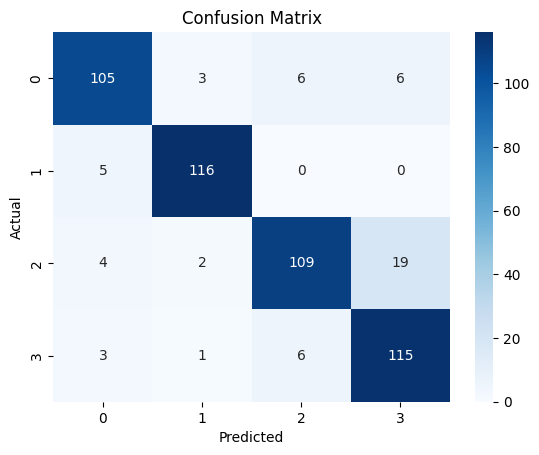

In [26]:
# confusion matrix 계산
cm = confusion_matrix(y_true, y_pred)

# 시각화
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
